In [2]:
# build a neural network which could learn transformations between two images
# using pytorch
# the network is trained on a dataset of 1000 images of size 32x32 from CIFAR-10

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                train=True,
                                                transform=transform,
                                                download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                  train=False,
                                                  transform=transform)

Files already downloaded and verified


In [4]:
# custom dataset using CIFAR-10
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        # random rotation
        ind = np.random.randint(0, 3)
        angle = ind * 90
        img_r = transforms.functional.rotate(img, angle)
        return img, img_r, ind

# test custom dataset
custom_train_dataset = CustomDataset(train_dataset)
custom_test_dataset = CustomDataset(test_dataset)

# create subset of images
# custom_train_dataset.dataset.data = custom_train_dataset.dataset.data[:10000]
# custom_test_dataset.dataset.data = custom_test_dataset.dataset.data[:10000]

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=custom_train_dataset,
                                           batch_size=128,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=custom_test_dataset,
                                            batch_size=128,
                                            shuffle=False)


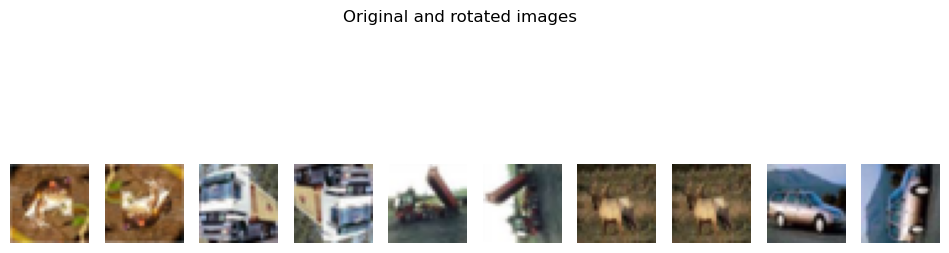

In [10]:
# plot some fixed images

def plot_images(imgs, title):
    fig, axs = plt.subplots(1, len(imgs), figsize=(12, 4))
    for i, img in enumerate(imgs):
        img = img.permute(1, 2, 0)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

fixed_imgs = []
for i in range(5):
    img, img_r, angle = custom_train_dataset[i]
    fixed_imgs.append(img)
    fixed_imgs.append(img_r)

plot_images(fixed_imgs, 'Original and rotated images')

In [130]:
# neural network

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.fc1 = nn.Linear(64, 100)
        # latent space for rotation
        self.fc2 = nn.Linear(100, 4)

        # add an autoencoder, here we also input the original image to the decoder
        self.softmax = nn.Softmax(dim=1)
        # encoder
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(32 * 32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(13, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32 * 32),
            torch.nn.Sigmoid()
        )


    def forward(self, x1, x2):
        x1_copy = x1
        x1 = self.conv1(x1)
        x1 = torch.relu(x1)
        x1 = torch.max_pool2d(x1, 2)
        x1 = self.conv2(x1)
        x1 = torch.relu(x1)
        x1 = torch.max_pool2d(x1, 2)

        x2 = self.conv1(x2)
        x2 = torch.relu(x2)
        x2 = torch.max_pool2d(x2, 2)
        x2 = self.conv2(x2)
        x2 = torch.relu(x2)
        x2 = torch.max_pool2d(x2, 2)

        x = torch.cat((x1, x2), 1)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        r = self.softmax(x)
        r = torch.stack((r, r, r), 1)
        x_r = self.encoder(x1_copy.view(x1.shape[0], -1, 32 * 32))
        x_r = torch.cat((x_r, r), -1)
        x_r = self.decoder(x_r)
        x_r = x_r.view(-1, 3, 32, 32)

        return x, x_r

In [132]:
from torchsummary import summary
model = NeuralNet().to(device)
summary(model, [(3, 32, 32), (3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
            Conv2d-2           [-1, 32, 10, 10]          12,832
            Conv2d-3           [-1, 16, 28, 28]           1,216
            Conv2d-4           [-1, 32, 10, 10]          12,832
            Conv2d-5             [-1, 64, 1, 1]         102,464
            Linear-6                  [-1, 100]           6,500
            Linear-7                    [-1, 4]             404
           Softmax-8                    [-1, 4]               0
            Linear-9               [-1, 3, 128]         131,200
             ReLU-10               [-1, 3, 128]               0
           Linear-11                [-1, 3, 64]           8,256
             ReLU-12                [-1, 3, 64]               0
           Linear-13                [-1, 3, 36]           2,340
             ReLU-14                [-1

In [215]:
def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_before = validate(model, testloader, device)
    print(f"Accuracy before training: {acc_before}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader):
            inputs1, inputs2, labels = data
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, outputs_img = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            mse = nn.MSELoss()
            loss2 = mse(outputs_img, inputs2)
            loss = loss + loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [216]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images1, images2, labels in testloader:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
            outputs, _ = model(images1, images2)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [217]:
model = NeuralNet()
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [164]:
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=500, device=device)

Accuracy before training: 0.329


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


Epoch 1, loss: 0.5729086705104774
Accuracy on train set: 0.9949
Accuracy on test set: 0.9955


100%|██████████| 391/391 [00:22<00:00, 17.55it/s]


Epoch 2, loss: 0.09260176697655408
Accuracy on train set: 0.99374
Accuracy on test set: 0.9942


100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Epoch 3, loss: 0.0737292214065714
Accuracy on train set: 0.98332
Accuracy on test set: 0.9831


100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Epoch 4, loss: 0.06634799287180461
Accuracy on train set: 0.97614
Accuracy on test set: 0.9737


 33%|███▎      | 128/391 [00:07<00:16, 16.36it/s]


KeyboardInterrupt: 

Predicted angle: 2, true angle: 2


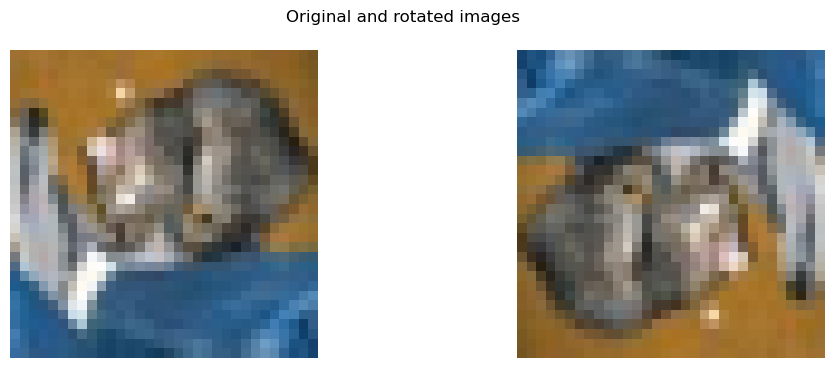

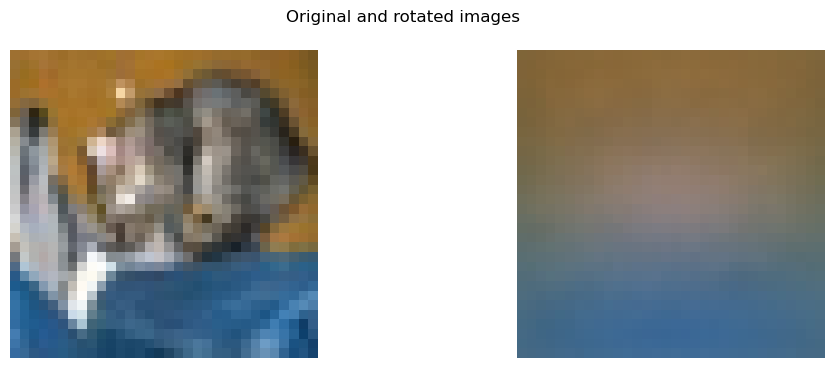

In [214]:
# test the model on some images
model.to(device)
model.eval()
image1, image2, angle = custom_test_dataset[0]
image1 = image1.unsqueeze(0).to(device)
image2 = image2.unsqueeze(0).to(device)
angle = torch.tensor(angle).to(device)
output, output_img = model(image1, image2)
output = torch.argmax(output, 1)
print(f"Predicted angle: {output.item()}, true angle: {angle.item()}")

plot_images([image1.cpu().squeeze(), image2.cpu().squeeze()], 'Original and rotated images')
plot_images([image1.cpu().squeeze(), output_img.detach().cpu().squeeze()], 'Original and rotated images')